### Import libraries.

In [1]:
import os
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Global variables.

In [2]:
CLASS_NAMES= [
  'airplane', 
  'automobile', 
  'bird', 
  'cat', 
  'deer', 
  'dog', 
  'frog', 
  'horse', 
  'ship', 
  'truck'
]

### Read and split dataset.

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

test_images, test_labels = test_images[: 5000], test_labels[: 5000]
train_images_new, train_labels_new = train_images[: 5000], train_labels[: 5000]
validation_images, validation_labels = train_images[5000 : 6000], train_labels[5000 : 6000]

train_images, train_labels = train_images_new, train_labels_new

In [4]:
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

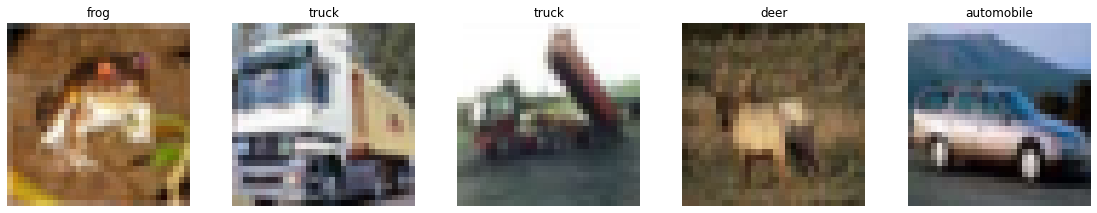

In [5]:
plt.figure(figsize=(80, 80))

for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(20, 20, i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

In [6]:
def process_images(image, label):
    
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    
    return image, label

In [7]:
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()

print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 5000
Test data size: 5000
Validation data size: 1000


In [8]:
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [10]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.optimizers.SGD(lr=0.001), 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                    patience=1, 
                                    verbose=1),
]


model.fit(train_ds,
          epochs=10,
          batch_size=128,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=callbacks)

Epoch 1/10
  6/156 [>.............................] - ETA: 7:05 - loss: 4.8121 - accuracy: 0.1183

In [ ]:
model.evaluate(test_ds)